# PHYS20762 - Project - 

David Phelan  
University of Manchester  
March 2025

This project aims to simulate a driven, damped harmonic oscillator.

In [34]:
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [35]:
# Initilisation
import numpy as np
import matplotlib.pyplot as plt
import cmath

The below function is an Euler solution to the equation of motion:

$m \frac{d^2 x(t)}{dt^2} + b \frac{d x(t)}{dt} + kx(t) = F(t),$

where the external force, $F(t)$ is $0$ (not driven) and accepting m, b, and k as inputs.

Base class of generic simulation that all future simulations extend

In [36]:
class Simulation:
    """Base simulation class for a mass-spring-damper system."""
    def __init__(self, name, m, k, b, n, t, x0, v0):
        self.name = name
        self.mass = m
        self.spring_constant = k
        self.damping_coefficient = b
        self.steps = n
        self.points = n + 1
        self.runtime = t
        self.initial_position = x0
        self.initial_velocity = v0
        self.time_step = t/n
    
    def simulate_at_position(self, i, position_array, velocity_array, acceleration_array):
        return self.simulate_at_time(position_array[i], velocity_array[i], acceleration_array[i])

    def simulate_at_time(self, x_current, v_current, a_current):
        """
        Called by simulate() at each time step.
        Must return (position, velocity, acceleration) at step i.
        """
        raise NotImplementedError("Override this method in subclasses.")

    def simulate(self):
        # Create arrays for time, position, velocity, acceleration
        time_array = np.linspace(0, self.runtime, self.points)
        position_array = np.zeros(self.points)
        velocity_array = np.zeros(self.points)
        acceleration_array = np.zeros(self.points)

        # Set initial conditions
        position_array[0] = self.initial_position
        velocity_array[0] = self.initial_velocity
        acceleration_array[0] = -(self.spring_constant * self.initial_position + self.damping_coefficient * self.initial_velocity) / self.mass

        # Step through in time
        for i in range(self.steps):

            # Delegate to the subclass for the actual step
            x_next, v_next, a_next = self.simulate_at_position(i, position_array, velocity_array, acceleration_array)
            position_array[i+1] = x_next
            velocity_array[i+1] = v_next
            acceleration_array[i+1] = a_next

        return position_array, velocity_array, acceleration_array, time_array

This is an implementation of an Euler simulation, extending the base simulation

In [37]:
class EulerSimulation(Simulation):
    def __init__(self, m, k, b, n, t, x0, v0):
        
        super().__init__("Euler", m, k, b, n, t, x0, v0)

    def simulate_at_time(self, x_current, v_current, a_current):
        
        x_next = x_current + v_current * self.time_step
        v_next = v_current + a_current * self.time_step
        a_next = -(self.spring_constant * x_next + self.damping_coefficient * v_next) / self.mass

        return x_next, v_next, a_next


The below function is an improved Euler solution to the equation of motion:

$m \frac{d^2 x(t)}{dt^2} + b \frac{d x(t)}{dt} + kx(t) = F(t),$

where the external force, $F(t)$ is $0$ (not driven) and accepting m, b, and k as inputs.

In [38]:
class ImprovedEulerSimulation(Simulation):
    def __init__(self, m, k, b, n, t, x0, v0):
        
        super().__init__("Improved Euler", m, k, b, n, t, x0, v0)

    def simulate_at_time(self, x_current, v_current, a_current):
        
        x_next = x_current + v_current * self.time_step + 0.5 * self.time_step**2 * a_current
        v_next = v_current + a_current * self.time_step
        a_next = -(self.spring_constant * x_next + self.damping_coefficient * v_next) / self.mass

        return x_next, v_next, a_next

The below function is an Euler-Cromer solution to the equation of motion:

$m \frac{d^2 x(t)}{dt^2} + b \frac{d x(t)}{dt} + kx(t) = F(t),$

where the external force, $F(t)$ is $0$ (not driven) and accepting m, b, and k as inputs.

In [39]:
class EulerCromerSimulation(Simulation):
    def __init__(self, m, k, b, n, t, x0, v0):
        
        super().__init__("Euler Cromer", m, k, b, n, t, x0, v0)

    def simulate_at_time(self, x_current, v_current, a_current):
        
        v_next = v_current + a_current * self.time_step
        x_next = x_current + v_next * self.time_step
        a_next = -(self.spring_constant * x_next + self.damping_coefficient * v_next) / self.mass

        return x_next, v_next, a_next

Verlet

In [40]:
class VerletSimulation(Simulation):
    def __init__(self, m, k, b, n, t, x0, v0):       
        super().__init__("Verlet", m, k, b, n, t, x0, v0)
        self.D = 2*m + b*self.time_step
        self.A = 2.0*(2*m - k*(self.time_step**2)) / self.D
        self.B = (b*self.time_step - 2*m) / self.D

    def simulate_at_position(self, i, position_array, velocity_array, acceleration_array):
      if i == 0:
        x_next = position_array[0] + velocity_array[0] * self.time_step + 0.5 * self.time_step**2 * acceleration_array[0]
        v_next = velocity_array[0] + acceleration_array[0] * self.time_step
        a_next = -(self.spring_constant * x_next + self.damping_coefficient * v_next) / self.mass
      
      else:
        x_next = self.A * position_array[i] + self.B * position_array[i-1]
        v_next = (x_next - position_array[i]) / self.time_step #?
        a_next = -(self.spring_constant * x_next + self.damping_coefficient * v_next) / self.mass #?

      return x_next, v_next, a_next

Analytical solution

In [41]:
def analytical_solution(m,k,b,t,x0,v0):

    time = t
    omega_damped = cmath.sqrt(4*k*m-b**2)
    A = (b/(2*1j*omega_damped)+1/2)*x0+v0*m/(omega_damped*1j) 
    B = x0-A
    
    exponential_component = np.exp(-b*time/(2*m))
    sinusoidal_component = (A*np.exp(1j*omega_damped*time/(2*m))
                            +B*np.exp(-1j*omega_damped*time/(2*m)))

    return sinusoidal_component * exponential_component

Plotting each method vs analytical solution for no damping

In [42]:
def plot_simulation(mass, spring_constant, damping_coefficient_array, step_array, runtime, initial_position, initial_velocity, simulation_type_array, include_analytical):

    for simulation_type in simulation_type_array:

        for damping_coefficient in damping_coefficient_array:

            for step in step_array:

                # Compute the solution
                simulation = simulation_type(mass, spring_constant, damping_coefficient, step, runtime, initial_position, initial_velocity)
                position, velocity, acceleration, time_array = simulation.simulate()
                # Plot the position vs time
                plt.plot(time_array, position, label=simulation.name, linestyle='--')

                if include_analytical:
                    plt.plot(time_array, analytical_solution(mass, spring_constant, damping_coefficient, time_array, initial_position, initial_velocity), label='Analytical', linestyle='--')

        plt.title('Position vs Time')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.legend()
        plt.show()

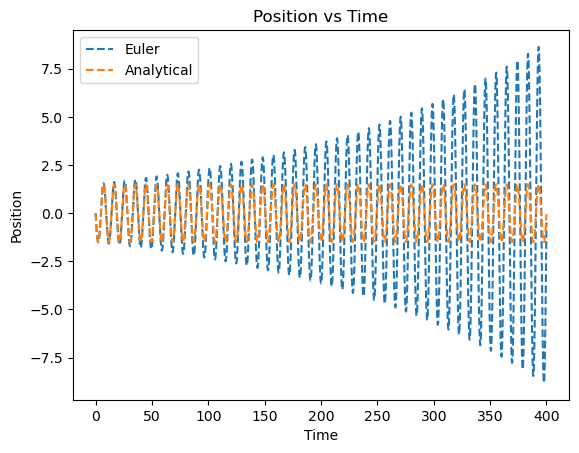

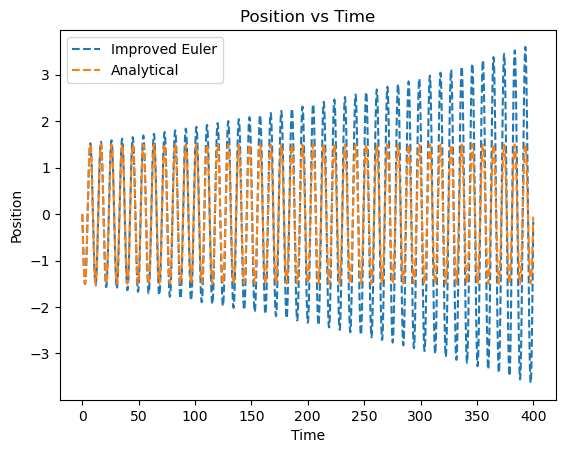

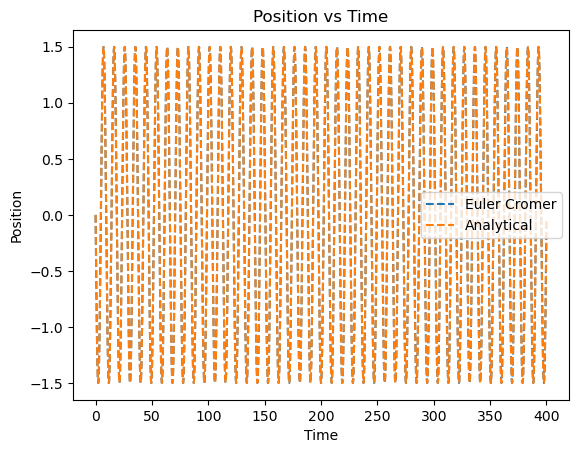

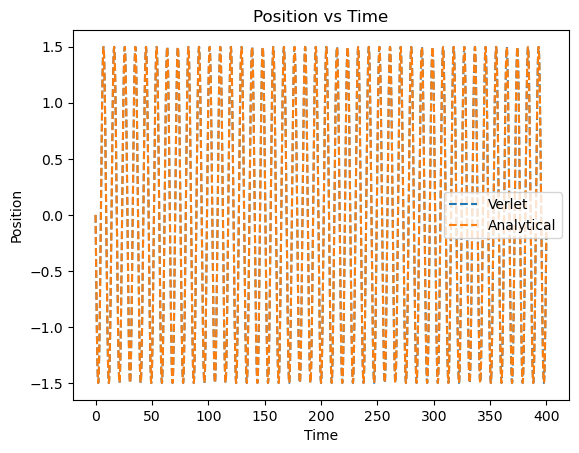

In [43]:
plot_simulation(3.03, 1.35, [0], [20000], 400, 0, -1, [EulerSimulation, ImprovedEulerSimulation, EulerCromerSimulation, VerletSimulation], True)

Now using different time step values to see effects on each method

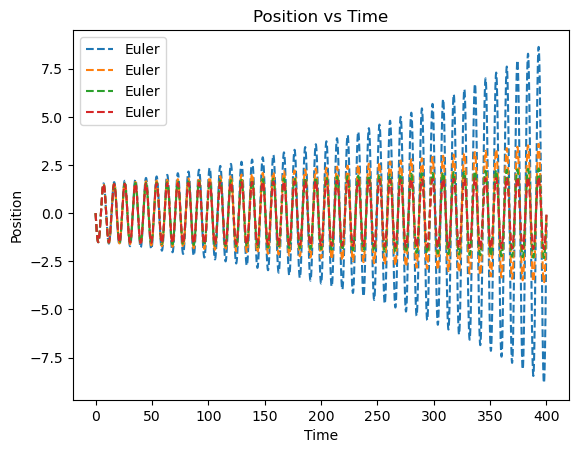

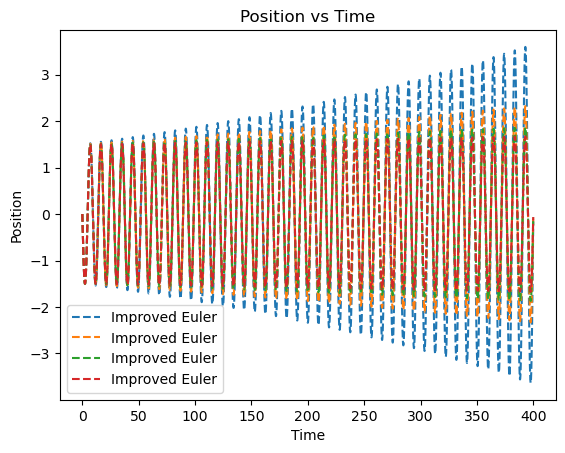

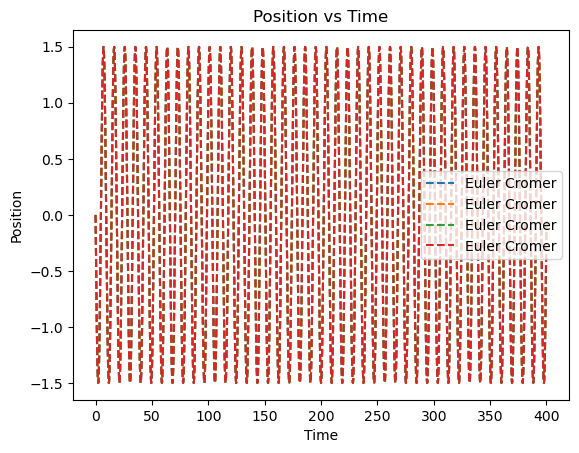

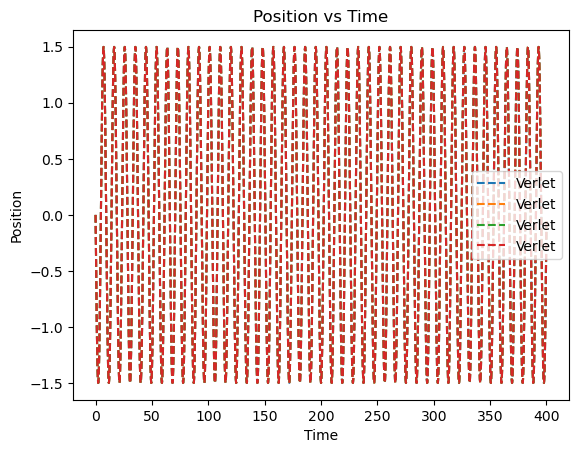

In [44]:
plot_simulation(3.03, 1.35, [0], np.array([20000, 40000, 80000, 160000]), 400, 0, -1, [EulerSimulation, ImprovedEulerSimulation, EulerCromerSimulation, VerletSimulation], False)

The accuracy of Euler and ImprovedEuler greatly improves upon decreasing step size, whereas Euler-Cromer and Verlet are perfectly accurate from the beginning
- can see accuracy improves because the energy no longer diverges but remains more constant as step size decreases (it should be constant for no damping and no external force)
So to investigate further, let's look at how increased damping affects accuracy to explore the further two
Using greatest step size explored earlier since it makes the most accurate solution
For the above graphs - do I want to add the analytical solution? How would I? Clutter?

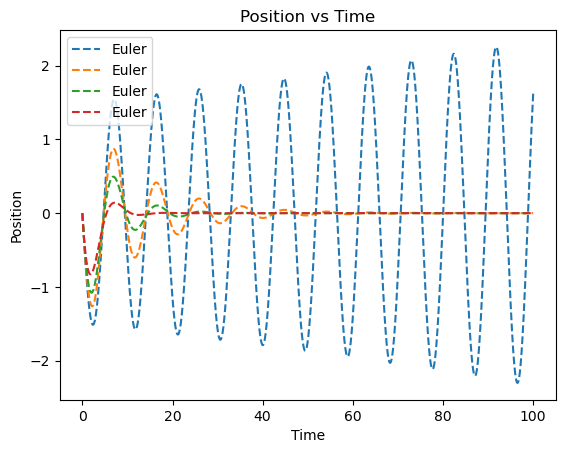

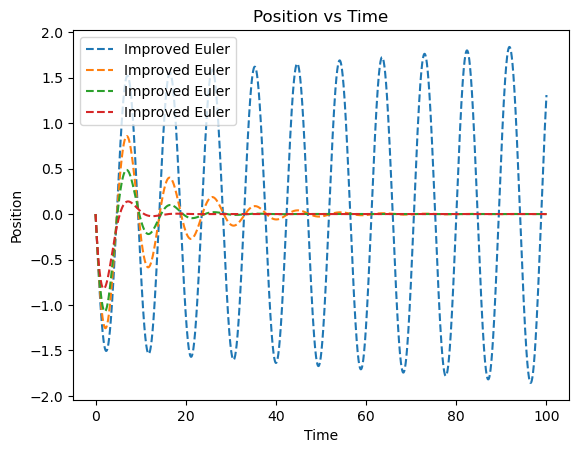

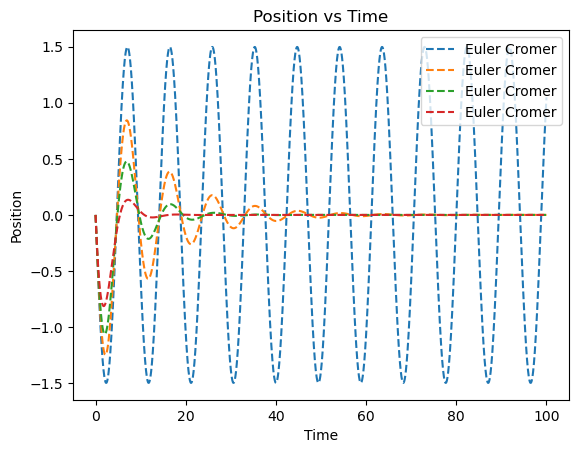

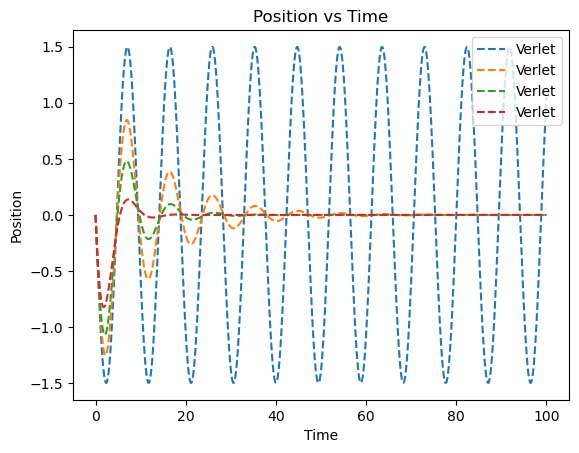

In [45]:
plot_simulation(3.03, 1.35, [0, 0.5, 1, 2], [5000], 100, 0, -1, [EulerSimulation, ImprovedEulerSimulation, EulerCromerSimulation, VerletSimulation], False)

Need to say stuff like as you can see, so and so is the most accurate
Problem: why are Euler-Cromer and Verlet identical?

Moving forward with the best chosen method, here it is for a variety of damping coefficients

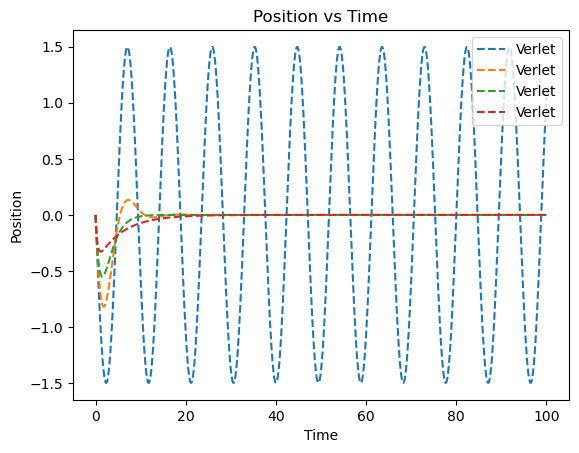

In [52]:
b_critical = np.sqrt(4*3.03*1.35)
plot_simulation(3.03, 1.35, np.array([0, 0.5*b_critical, b_critical, 2*b_critical]), [5000], 100, 0, -1, [VerletSimulation], False)

Now for analytical
Come back to the below:
Analytical solution graphs, not asked for but I think I should put them alongside the best chosen method when doing different dampings

In [47]:
'''
# Parameters
m = 3.03
k = 1.35
b_critical = np.sqrt(4*m*k)
b_values = np.array([0, 0.5*b_critical, b_critical, 2*b_critical])
n = 5000
t = 100
x0 = 0
v0 = -1
dt = t/n

plt.figure(figsize=(8, 5))  # Create a new figure for each method
print(len(time_array))

for b in b_values:
    # Compute the solution
    x = analytical_solution(m, k, b, n, time_array, x0, v0, dt)

    # Plot the position vs time
    plt.plot(time_array, x, label=f"{analytical_solution.__name__} (b={b})", linestyle='--')

plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.show()
'''

'\n# Parameters\nm = 3.03\nk = 1.35\nb_critical = np.sqrt(4*m*k)\nb_values = np.array([0, 0.5*b_critical, b_critical, 2*b_critical])\nn = 5000\nt = 100\nx0 = 0\nv0 = -1\ndt = t/n\n\nplt.figure(figsize=(8, 5))  # Create a new figure for each method\nprint(len(time_array))\n\nfor b in b_values:\n    # Compute the solution\n    x = analytical_solution(m, k, b, n, time_array, x0, v0, dt)\n\n    # Plot the position vs time\n    plt.plot(time_array, x, label=f"{analytical_solution.__name__} (b={b})", linestyle=\'--\')\n\nplt.xlabel(\'Time\')\nplt.ylabel(\'Position\')\nplt.legend()\nplt.show()\n'

Discussion here about different damping solutions

Come back to:
We are using analytical methods to check numerical methods for when we can't use analytical . e.g. when F is present
best benchmark is analytical solution
symplectic vs not methods - use symplectic
video 2 has lots of good info (listen not just watch slides)

Questions
If I use extra numerical methods and one is more accurate than the 4 provided, am I okay to use that for the rest of the report?
Talk about errors, watch third video. Maybe plot error (model - analytical values) vs time graph
Do I need to leave a blank like at the end of cells? Like last module wanted
Euler - original vs my method. Can I be calculating a[i+1]? Does that violate Euler principles
Comparing the two test Euler functions I have, why does the new one (with the same logic as far as I can see where F and t_F both = 0) produce a different graph than old one?

Doing tests to make sure things work

In [48]:
def test_Euler_simulation():
    """
    Tests the Euler_undriven function in simple edge cases
    to confirm that the solver behaves as expected.
    
    Scenario 1: 
        - m=1, k=0, b=0, x0=0, v0=0, dt=0.1
        - Expect no forces and no initial motion => everything remains zero.
    
    Scenario 2:
        - m=1, k=0, b=0, x0=2, v0=-1, dt=0.1
        - Expect velocity remains constant at -1, 
          position decreases linearly with slope -1, 
          acceleration is always zero.
    """
    # -- Scenario 1: no forces and no initial velocity --
    from_module = Euler_driven(m=1, k=0, b=0, x0=0, v0=0, dt=0.1, n=10)
    x_arr, v_arr, a_arr, t_arr = from_module
    
    # Our expected arrays: everything should be zero (length n_stneps+1 = 11)
    zeros_11 = np.zeros(11)
    
    # Assert they match (within floating-point tolerance)
    assert np.allclose(x_arr, zeros_11), "Scenario 1: x should remain zero."
    assert np.allclose(v_arr, zeros_11), "Scenario 1: v should remain zero."
    assert np.allclose(a_arr, zeros_11), "Scenario 1: a should remain zero."
    
    # -- Scenario 2: constant velocity, no forces --
    from_module = Euler_driven(m=1, k=0, b=0, x0=2, v0=-1, dt=0.1, n=10)
    x_arr, v_arr, a_arr, t_arr = from_module
    
    # Time array for reference
    # t_arr = [0.0, 0.1, 0.2, ..., 1.0] (length = 11)
    
    # The velocity should remain at -1:
    expected_v = -1 * np.ones_like(t_arr)
    # The position should be x(t) = 2 + v0 * t = 2 - 1 * t
    expected_x = 2 - t_arr
    # Acceleration should be zero (no spring, no damping)
    expected_a = np.zeros_like(t_arr)
    
    assert np.allclose(v_arr, expected_v),  "Scenario 2: velocity should stay at -1."
    assert np.allclose(x_arr, expected_x),  "Scenario 2: position should be linear in time."
    assert np.allclose(a_arr, expected_a),  "Scenario 2: acceleration should remain zero."
    
    print("All Euler_undriven tests passed successfully!")

#test_Euler_undriven()

In [49]:
def test_ImprovedEuler_undriven():
    """
    Tests the Improved Euler (2nd-order Taylor) method in simple edge cases:
    
    Scenario 1: 
        k=0, b=0, v0=0 => no force, no initial velocity
        Expected: The mass stays at the initial position, with zero velocity/acceleration.

    Scenario 2: 
        k=0, b=0, v0 != 0 => no force, nonzero initial velocity
        Expected: The mass moves with constant velocity (v0) 
                  so x(t) = x0 + v0 * t, and a(t) = 0.
    """
    
    # -----------------------------
    # Scenario 1: No force, no initial motion
    # -----------------------------
    from_func = ImprovedEuler_undriven(m=1, k=0, b=0, n=10, x0=2, v0=0, dt=0.1)
    x_arr, v_arr, a_arr, t_arr = from_func
    
    # All values should remain exactly the initial position, 
    # with zero velocity and zero acceleration.
    expected_x = np.full_like(t_arr, 2.0)  # always at x=2
    expected_v = np.zeros_like(t_arr)
    expected_a = np.zeros_like(t_arr)
    
    assert np.allclose(x_arr, expected_x), "Scenario 1: position should remain constant at 2."
    assert np.allclose(v_arr, expected_v), "Scenario 1: velocity should remain zero."
    assert np.allclose(a_arr, expected_a), "Scenario 1: acceleration should remain zero."

    # -----------------------------
    # Scenario 2: No force, but nonzero initial velocity
    # -----------------------------
    from_func = ImprovedEuler_undriven(m=1, k=0, b=0, n=10, x0=2, v0=-1, dt=0.1)
    x_arr, v_arr, a_arr, t_arr = from_func
    
    # Velocity should stay at -1, position should decrease linearly
    # x(t) = x0 + v0 * t = 2 - t
    expected_v = -1.0 * np.ones_like(t_arr)
    expected_x = 2.0 + (-1.0)*t_arr
    expected_a = np.zeros_like(t_arr)
    
    assert np.allclose(v_arr, expected_v),  "Scenario 2: velocity should remain constant at -1."
    assert np.allclose(x_arr, expected_x),  "Scenario 2: position should be 2 - t."
    assert np.allclose(a_arr, expected_a),  "Scenario 2: acceleration should remain zero."

    print("All tests for the Improved Euler (2nd-order) method passed successfully!")

#test_ImprovedEuler_undriven()

In [50]:
def test_EulerCromer_undriven():
    """
    Tests the Euler-Cromer method in simple edge cases:
    
    1) No force, no initial velocity => the mass should remain at rest.
    2) No force, nonzero initial velocity => the mass moves at constant velocity.
    """
    # --- Scenario 1: No force, no motion ---
    x_arr, v_arr, a_arr, t_arr = EulerCromer_undriven(
        m=1, k=0, b=0, n=10, x0=5, v0=0, dt=0.1
    )
    # Expect position=constant=5, velocity=0, acceleration=0
    expected_x = np.full_like(t_arr, 5.0)
    expected_v = np.zeros_like(t_arr)
    expected_a = np.zeros_like(t_arr)

    assert np.allclose(x_arr, expected_x), "Scenario 1: x should remain at 5."
    assert np.allclose(v_arr, expected_v), "Scenario 1: v should remain 0."
    assert np.allclose(a_arr, expected_a), "Scenario 1: a should remain 0."

    # --- Scenario 2: No force, constant velocity ---
    x_arr, v_arr, a_arr, t_arr = EulerCromer_undriven(
        m=1, k=0, b=0, n=10, x0=5, v0=2, dt=0.1
    )
    # Velocity=2, so x(t)=5 + 2*t, a(t)=0
    expected_v = np.full_like(t_arr, 2.0)
    expected_x = 5 + 2*t_arr
    expected_a = np.zeros_like(t_arr)

    assert np.allclose(v_arr, expected_v), "Scenario 2: velocity should remain 2."
    assert np.allclose(x_arr, expected_x), "Scenario 2: position should be 5 + 2*t."
    assert np.allclose(a_arr, expected_a), "Scenario 2: acceleration should remain 0."

    print("All Euler-Cromer tests passed successfully!")

#test_EulerCromer_undriven()

In [51]:
def test_Verlet_undriven():
    # Case 1: No force, no initial velocity => remain at rest, x=constant
    x_arr, v_arr, a_arr, t_arr = Verlet_undriven(m=1, k=0, b=0, n=10, x0=2, v0=0, dt=0.1)
    assert np.allclose(x_arr, 2), "Position should remain at x=2."
    assert np.allclose(v_arr, 0), "Velocity should stay zero."
    assert np.allclose(a_arr, 0), "Acceleration should be zero."

    # Case 2: No force, constant nonzero velocity => x(t)=x0 + v0*t
    x_arr, v_arr, a_arr, t_arr = Verlet_undriven(m=1, k=0, b=0, n=10, x0=3, v0=1, dt=0.1)
    expected_x = 3 + t_arr*1.0
    assert np.allclose(x_arr, expected_x), "Position should be x0 + v0*t."
    assert np.allclose(v_arr, 1.0), "Velocity should remain constant at 1."
    assert np.allclose(a_arr, 0), "Acceleration should remain zero."
    
    print("All Verlet_undriven tests passed!")

#test_Verlet_undriven()